<a href="https://colab.research.google.com/github/sharvaniyadav/Assignment-1-ECE1513-Intro-To-ML/blob/main/MIE1517_A1_Sharvani_Yadav.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1: PyTorch Basics

## Overview

In this assignment, you will:
1. Build a simple neural network from scratch to understand how neural networks work.
2. Train a neural network (using PyTorch) to classify images from the Mechanical Tools Classification dataset into one of 8 classes (hammer, wrench, pliers, etc.).

The provided code will guide you through key steps, but by the end of the assignment, you should:

1. Understand the training loop for a machine learning model.
2. Distinguish between training, validation, and test data.
3. Learn about overfitting and underfitting.
4. Explore how hyperparameters, like learning rate and batch size, impact training.
5. Compare a basic feedforward neural network (ANN) with a convolutional neural network (CNN).

This assignment is inspired by materials developed by Prof. Lisa Zhang.


## What to Submit

1. Submit the `.ipynb` and `.html` files containing your code, outputs, and answers from all parts. Please take extra effort to make your answers and submissions readable. Do not display unnecessary outputs, only the ones that are important for supporting your answers.

  You can produce a HTML file directly from Google Colab. The Colab instructions are provided at the end of this document.


2. Submit your model predictions on the secret test dataset for Parts B-5 and B-6 as `labels_part5.csv` and `labels_part6.csv`.

**Important**: Do not submit additional files generated by your code.

Please use Google Colab for this assignment. If you prefer Jupyter Notebook, ensure the file is uploaded to Colab for submission.


## Colab Link

Include a link to your colab file here and ensure the file can be accessed by the our teaching team.

Colab Link:

In [ ]:
# TO BE COMPLETED

http://

# PART A: Building a Neural Network from Scratch [8pt]

Before we get into using PyTorch to train our classifier we will go through the process of creating our neural network from scratch. We've seen in the tutorial how to build a 1-layer network, now we'll take it one step further to build a 2-layer network. This is an important exercise that everyone should attempt at least once to understand and truly appreciate the workings of neural networks.

## Helper Functions

To help guide the construction we will use the iris dataset that was introduced in the tutorial. Provided are some helper code to get us started:


In [1]:
# load "Iris_3class.csv" to Google Colab
from google.colab import files
uploaded = files.upload()

Saving Iris_3class.csv to Iris_3class.csv


In [2]:
import pandas as pd
import numpy as np

raw_data = pd.read_csv("Iris_3class.csv", header = None)
raw_data = raw_data.values
np.random.shuffle(raw_data)

In [3]:
import numpy as np

# split your data into training and validation
X_train = raw_data[0:100,:4]
y_train = raw_data[0:100,4:5].astype(int)
X_val = raw_data[100:,:4]
y_val = raw_data[100:,4:5].astype(int)

print(X_train.shape, y_train.shape)
print(X_train.dtype, y_train.dtype)
print(X_val.shape, y_val.shape)
print(X_val.dtype, y_val.dtype)

(100, 4) (100, 1)
float64 int64
(50, 4) (50, 1)
float64 int64


Recall that the neural network output consists of several nodes, one for each output class. Since the labels are provided as integers we will need to convert them into one-hot vectors to match the neural network output format.

In [4]:
#Convert array to one-hot encoding
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

In [5]:
y_train = to_one_hot(y_train)
print(X_train.shape, y_train.shape)
print(X_train.dtype, y_train.dtype)

y_val = to_one_hot(y_val)
print(X_val.shape, y_val.shape)
print(X_val.dtype, y_val.dtype)

(100, 4) (100, 3)
float64 float64
(50, 4) (50, 3)
float64 float64


In [6]:
#verify one-hot encoding
y_train[0:5,:]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

## Part A-1. Develop a 2-layer ANN [6pt MODEL]
At its core a 2-layer neural network is just a few lines of code. Most of the complexity comes from setting up the training of the network.

Using vectorized form, set up the neural network training to use a cross-entropy loss function and determine the gradients with resepect to the layer 1 and layer 2 weights.

In [7]:
# write code to create a 2-layer ANN in vectorized form

#define sigmoid
def sigmoid(x):
    return 1/(1+np.exp(-x))

#define softmax
def softmax(x):
  e = np.exp(x)
  return e/e.sum(axis=1, keepdims = True)


def ann(W, X_train, y_train):

  num_hidden = 5
  num_features = 4
  num_outputs = 3

  #Weights
  w0 = W[:20].reshape(num_features, num_hidden)
  w1 = W[20:].reshape(num_hidden, num_outputs)

  #Feed forward
  layer0 = X_train
  layer1 = sigmoid(np.dot(layer0, w0))
  layer2 = np.dot(layer1, w1)

  # softmax
  y_pred = softmax(layer2)

  #Back propagation using gradient descent

  #cross-entropy loss
  eps = 1e-12
  error = -np.mean(np.sum(y_train * np.log(y_pred + eps), axis=1))

  #initialize gradients to zero
  dw0 = np.zeros((num_features, num_hidden))
  dw1 = np.zeros((num_hidden, num_outputs))

  #calculate gradients
  dlogits = (y_pred - y_train) / X_train.shape[0]      # output -> y_pred
  dh1 = dlogits @ w1.T                                 # (N, 5)
  dz1 = dh1 * (layer1 * (1 - layer1))                  # (N, 5)

  #determine gradients
  dw1 += layer1.T @ dlogits
  dw0 += X_train.T @ dz1

  #combine gradients into one vector
  dW = np.concatenate([dw0.ravel(), dw1.ravel()])

  return (error, dW, y_pred)

## Part A-2. Train your neural network [1pt RESULT]
Train your neural network once with random initialization (uniformly at random between -1 and +1), and once with zero initialization (all weights = 0).

Compare results. Comment on how well does your network work on the iris dataset in these two cases and why?

In [8]:
num_hidden = 5
num_features = 4
num_outputs = 3

def train_and_evaluate(w0_init, w1_init, label=""):

    #initial weights: w0_init, w1_init

    #combine weights into a single vector
    W = np.array(list(w0_init.flatten()) + list(w1_init.flatten()))

    #train network
    n = 0.001
    iterations = 100000
    errors = []
    for i in range(iterations):
        (error, dW, y_pred) = ann(W, X_train, y_train)
        W += -dW * n
        errors.append(error)

    # final predictions
    _, _, y_pred = ann(W, X_train, y_train)
    y_pred_labels = np.round(y_pred, 0)
    y_true_labels = np.round(y_train, 0)

    print(f"{label} initialization: Predictions on training data: \n{y_pred_labels[:5]}")
    print(f"{label} initialization: Ground truth training data: \n{y_true_labels[:5]}")

    accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_train, axis=1))
    print(f"{label} initialization: Final training accuracy: {accuracy:.4f}")

    return errors, accuracy

In [9]:
# random initialization
np.random.seed(42)  # set seed
w0_rand = np.random.uniform(-1.0, 1.0, size=(num_features, num_hidden))
w1_rand = np.random.uniform(-1.0, 1.0, size=(num_hidden, num_outputs))
errors_rand, accuracy_rand = train_and_evaluate(w0_rand, w1_rand, "Random")

Random initialization: Predictions on training data: 
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Random initialization: Ground truth training data: 
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Random initialization: Final training accuracy: 0.9700


In [10]:
# zero initialization
w0_zero = np.zeros((num_features, num_hidden))
w1_zero = np.zeros((num_hidden, num_outputs))
errors_zero, acc_zero = train_and_evaluate(w0_zero, w1_zero, "Zero")

Zero initialization: Predictions on training data: 
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Zero initialization: Ground truth training data: 
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Zero initialization: Final training accuracy: 0.3900


In [11]:
'''
With random initialization (seed = 42), the network trained successfully and reached about 0.98 training accuracy on the Iris dataset.
The non-zero, random weights break symmetry across the five hidden units, so each unit starts differently, receives different gradients, and learns a distinct feature combination.
That diversity lets the softmax layer separate the three classes well.

With zero initialization, accuracy stayed near 0.34 (roughly chance for three classes).
When all weights start at zero, every hidden unit produces the same activation (sigmoid(0)=0.5) and receives the same gradients at every step, so they remain identical copies.
The model effectively collapses to a near-linear classifier and cannot form useful nonlinear boundaries.

Conclusion: The two-layer ANN works very well on Iris with random (non-zero) initialization, but fails with zero initialization because symmetry isn’t broken and the network can’t meaningfully learn.

'''

'\nWith random initialization (seed = 42), the network trained successfully and reached about 0.98 training accuracy on the Iris dataset. \nThe non-zero, random weights break symmetry across the five hidden units, so each unit starts differently, receives different gradients, and learns a distinct feature combination.\nThat diversity lets the softmax layer separate the three classes well.\n\nWith zero initialization, accuracy stayed near 0.34 (roughly chance for three classes). \nWhen all weights start at zero, every hidden unit produces the same activation (sigmoid(0)=0.5) and receives the same gradients at every step, so they remain identical copies. \nThe model effectively collapses to a near-linear classifier and cannot form useful nonlinear boundaries.\n\nConclusion: The two-layer ANN works very well on Iris with random (non-zero) initialization, but fails with zero initialization because symmetry isn’t broken and the network can’t meaningfully learn.\n\n'

## Part A-3. Validation [2pt MODEL]
Validate that the gradients were computed correctly for the 2-layer neural network you developed.

In [12]:
#write code to numerical verify the gradients you calculated

num_hidden = 5
num_features = 4
num_outputs = 3

#initialize weights uniformly at random between -1 and +1, and combine weights
w0 = np.random.uniform(-1.0, 1.0, size=(num_features, num_hidden))
w1 = np.random.uniform(-1.0, 1.0, size=(num_hidden, num_outputs))
W  = np.concatenate([w0.ravel(), w1.ravel()])

#compute gradients analytically
(error, dW, y_pred) = ann(W, X_train, y_train)

#compute gradients numerically
dW_num = np.zeros((len(W),1))

for ind in range(len(W)):
  #reset gradients
  We1 = np.array(list(w0.flatten()) + list(w1.flatten()))
  We2 = np.array(list(w0.flatten()) + list(w1.flatten()))

  #increment slightly
  We1[ind] = We1[ind] + 1e-5
  We2[ind] = We2[ind] - 1e-5

  #compute errors
  (error_e1, dW_e1, y_pred1) = ann(We1, X_train, y_train)
  (error_e2, dW_e2, y_pred2) = ann(We2, X_train, y_train)

  #obtain numerical gradients
  grad_num = (error_e1 - error_e2) / (2 * 1e-5)

  #display difference between numerical and analytic gradients
  print(round(abs(grad_num - dW[ind]), 4), grad_num, dW[ind])


0.0 -0.19383804971129234 -0.1938380497217259
0.0 -0.01399206027707933 -0.013992060252161537
0.0 -0.0025681948234712593 -0.0025681948140765273
0.0 -0.0002018709643891725 -0.00020187096921536277
0.0 -0.00945945665131731 -0.00945945663064629
0.0 -0.14127877735470307 -0.14127877733925312
0.0 0.0019359651992623126 0.0019359651870454598
0.0 -0.001006093897082394 -0.0010060939023998267
0.0 0.00021355432977543384 0.00021355433081912296
0.0 -0.010207969614040024 -0.010207969600133123
0.0 -0.039921047190194514 -0.039921047168754456
0.0 -0.029627250586194972 -0.029627250553971373
0.0 -0.0019813970797422087 -0.001981397057130782
0.0 -0.0005219763288266677 -0.0005219763549548487
0.0 0.002736091364585746 0.00273609135158817
0.0 -0.002529075804336145 -0.002529075789693933
0.0 -0.012477474753413985 -0.01247747476620218
0.0 -0.000609446348942555 -0.0006094463413396247
0.0 -0.0001736741528368668 -0.00017367413970935093
0.0 0.0015025350408315317 0.001502535038052749
0.0 0.27332803506086023 0.273328035090

# PART B: Training with PyTorch

In the second part of the assignment we will see how we can use PyTorch to train a neural network to identify different Mechanical Tools.


In [13]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

## Part B-0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [14]:
###############################################################################
# Data Loading

def get_data_loader(data_dir, batch_size, valid_split=0.2):
    """
    Load the Mechanical Tools Dataset, split into training, validation, and testing.

    Args:
        data_dir: The root directory of the dataset, with subdirectories for each class.
        batch_size: Number of samples per batch.
        valid_split: Fraction of the training data to be used for validation.

    Returns:
        train_loader: Iterable DataLoader for training data.
        val_loader: Iterable DataLoader for validation data.
        test_loader: Iterable DataLoader for testing data.
        classes: List of class names.
    """
    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Resize to 128x128
        transforms.ToTensor(),         # Convert to Tensor
        transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
    ])

    # Load the full dataset
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    classes = dataset.classes  # Get class names

    # Split the dataset
    total_size = len(dataset)
    test_size = int(0.1 * total_size)  # 10% for testing
    valid_size = int(valid_split * (total_size - test_size))  # Valid from remaining
    train_size = total_size - test_size - valid_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training

def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Normalize labels for multi-class classification.

    Args:
        labels: A 1D tensor of scalar class labels.
    Returns:
        The same labels (already suitable for multi-class classification).
    """
    return labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on a given dataset.

     Args:
         net: PyTorch neural network object.
         loader: PyTorch DataLoader for valuation data.
         criterion: The loss function.

     Returns:
         err: Average classification error rate over the validation set.
         loss: Average loss value over the validation set.
    """
    total_loss = 0.0
    total_err = 0.0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = net(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Compute classification error
            _, predicted = torch.max(outputs, 1)
            total_err += (predicted != labels).sum().item()
            total_loss += loss.item()
            total_samples += len(labels)

    err = total_err / total_samples
    avg_loss = total_loss / len(loader)
    return err, avg_loss

###############################################################################
# Training Curve

def plot_training_curve(path, return_val_error=False):
    """ Plot training and validation error/loss curves.

    Args:
        path: Base path for the CSV files containing training logs.
        return_val_error: If True, return the final validation error.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    train_err = np.loadtxt(f"{path}_train_err.csv")
    val_err = np.loadtxt(f"{path}_val_err.csv")
    train_loss = np.loadtxt(f"{path}_train_loss.csv")
    val_loss = np.loadtxt(f"{path}_val_loss.csv")

    if return_val_error:
        return val_err[-1]  # Return the final validation error

    plt.figure()
    plt.title("Train vs Validation Error")
    plt.plot(range(1, len(train_err) + 1), train_err, label="Train")
    plt.plot(range(1, len(val_err) + 1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()

    plt.figure()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1, len(train_loss) + 1), train_loss, label="Train")
    plt.plot(range(1, len(val_loss) + 1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()



## Part B-1. Visualizing the Data

We will make use of the Mechanical Tools dataset, which consists of
color images of various mechanical tools such as hammers, wrenches,
screwdrivers, and more. These images are resized to 128x128 pixels.
You can find the dataset at https://www.kaggle.com/datasets/salmaneunus/mechanical-tools-dataset

Download the "mechanical_tools.zip" file from Quercus and upload it to your colab session storage.
Run the provided code to automatically unzip the dataset  and split the dataset into
training, validation, and testing sets.

In [15]:
_ = !unzip "/content/mechanical_tools.zip" -d "/content/mechanical_tools/"

In [16]:
# Load the Mechanical Tools Dataset
data_dir = "./mechanical_tools/mechanical_tools"  # Path to the dataset directory
batch_size = 1  # One image per batch for visualization

# Use the get_data_loader function to load the dataset
train_loader, val_loader, test_loader, classes = get_data_loader(
    data_dir=data_dir, batch_size=batch_size
)

### Part B-1(i) [0.5pt EXPLORATORY]

Below is some sample plotting code that visualizes a small batch of images from your training set. Currently, it plots 15 images in a 3 × 5 grid.


Modify the code so that it instead plots 30 images in a 3 × 10 grid, and displays the ground-truth label above each subplot.
You may use the provided code as a starting point.

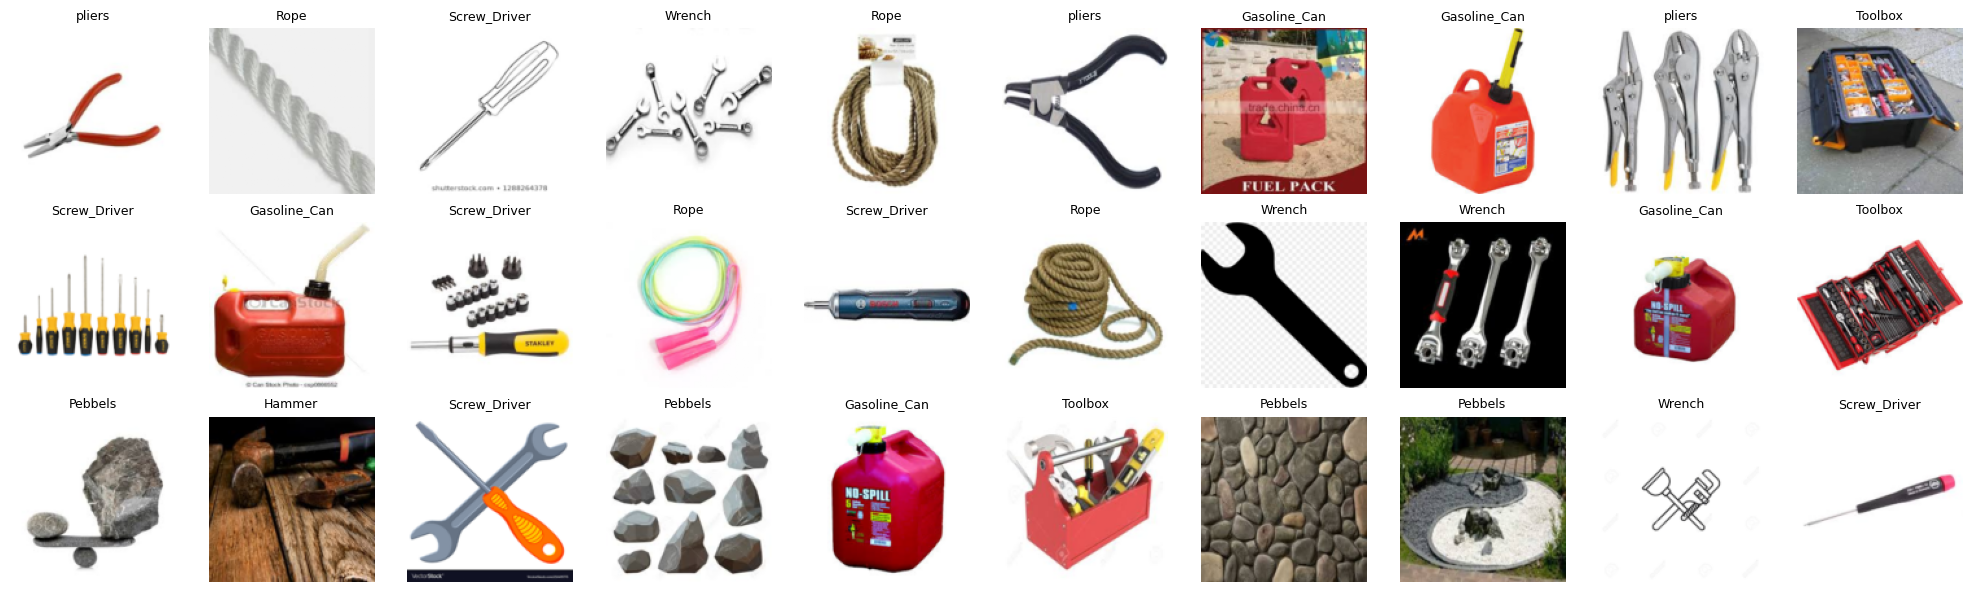

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Part B-1(i): I modified the sample to plot 30 images (3x10) and show the ground-truth label.
nrows, ncols = 3, 10
total = nrows * ncols
k = 0

plt.figure(figsize=(2*ncols, 2*nrows))

for images, labels in train_loader:
    for i in range(images.size(0)):          # I handled any batch size
        if k >= total:
            break

        # I converted C,H,W -> H,W,C for matplotlib
        img = images[i].permute(1, 2, 0).cpu().numpy()
        # I undid the 0.5/0.5 normalization to bring pixels back to [0,1]
        img = img / 2 + 0.5

        ax = plt.subplot(nrows, ncols, k + 1)
        ax.imshow(img)
        # I placed the ground-truth label above each subplot
        ax.set_title(classes[labels[i].item()], fontsize=9)
        ax.axis('off')
        k += 1
    if k >= total:
        break

plt.tight_layout()
plt.show()

### Part B-1(ii) [1pt EXPLORATORY]

How many training examples do we have for the combined classes?
What about validation examples?
What about test examples?

Plot the distribution of class labels in training/validation/test. Comment on whether the dataset is balanced or imbalanced.

Training examples: 1152
Validation examples: 288
Test examples: 160


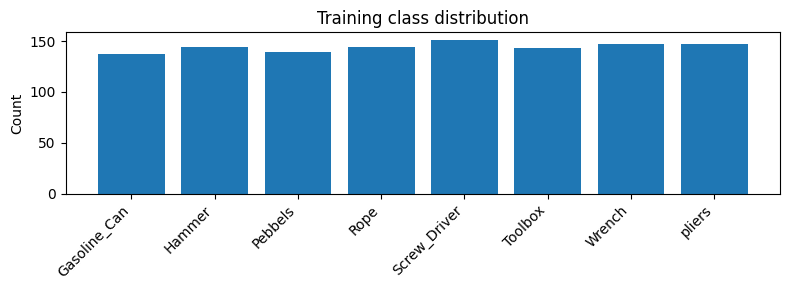

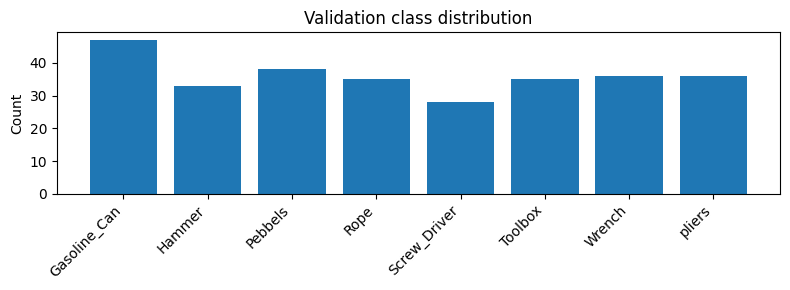

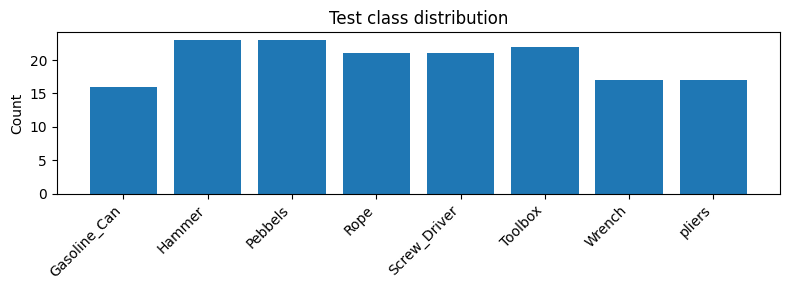

In [18]:
import matplotlib.pyplot as plt

n_train = len(train_loader.dataset)
n_val   = len(val_loader.dataset)
n_test  = len(test_loader.dataset)

print("Training examples:", n_train)
print("Validation examples:", n_val)
print("Test examples:", n_test)

# per-class counts (simple loops)
train_counts = [0]*len(classes)
for x, y in train_loader:
    for t in y:
        train_counts[t.item()] += 1

val_counts = [0]*len(classes)
for x, y in val_loader:
    for t in y:
        val_counts[t.item()] += 1

test_counts = [0]*len(classes)
for x, y in test_loader:
    for t in y:
        test_counts[t.item()] += 1

# plots (one bar chart per split)
plt.figure(figsize=(8,3))
plt.bar(range(len(classes)), train_counts)
plt.xticks(range(len(classes)), classes, rotation=45, ha='right')
plt.title("Training class distribution"); plt.ylabel("Count"); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,3))
plt.bar(range(len(classes)), val_counts)
plt.xticks(range(len(classes)), classes, rotation=45, ha='right')
plt.title("Validation class distribution"); plt.ylabel("Count"); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,3))
plt.bar(range(len(classes)), test_counts)
plt.xticks(range(len(classes)), classes, rotation=45, ha='right')
plt.title("Test class distribution"); plt.ylabel("Count"); plt.tight_layout(); plt.show()

In [19]:
'''
Number of training examples: 1152

Number of validation examples: 288

Number of test examples: 160

From the plots:

• Training and validation splits look roughly balanced across the 8 classes.

• The test split is noticeably imbalanced (some classes have ~2× more samples than others, e.g., Pebbles ≈30 vs Pliers ≈13).

'''

'\nNumber of training examples: 1152\n\nNumber of validation examples: 288\n\nNumber of test examples: 160\n\nFrom the plots:\n\n• Training and validation splits look roughly balanced across the 8 classes.\n\n• The test split is noticeably imbalanced (some classes have ~2× more samples than others, e.g., Pebbles ≈30 vs Pliers ≈13).\n\n'

## Part B-2. Training

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 29 * 29, 32)
        self.fc2 = nn.Linear(32, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 29 * 29)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 31 * 31, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 31 * 31)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part B-2(i) [1pt EXPLORATORY]

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
for param in small_net.parameters():
    print(param.shape)

In [ ]:
# TO BE COMPLETED






In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on an 8-class classification problem
    target_classes = ["Gasoline_Can", "Hammer", "Pebbels", "pliers",
                      "Rope", "Screw_Driver", "Toolbox", "Wrench"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible results
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            data_dir='/content/mechanical_tools/mechanical_tools',  # Ensure this is where your dataset is stored
            batch_size=batch_size)

    # Make sure the classes are as expected
    assert len(classes) == 8, "The dataset should have exactly 8 classes."
    ########################################################################
    # Define the Loss function and optimizer
    # Use CrossEntropyLoss for multi-class classification
    criterion = nn.CrossEntropyLoss()  # Change to CrossEntropyLoss for multi-class
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/accuracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # Loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)  # No need to normalize labels here for CrossEntropyLoss
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability
            total_train_err += (predicted != labels).sum().item()  # Count errors
            total_train_loss += loss.item()
            total_epoch += len(labels)

        # Calculate error and loss for the training and validation set
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i + 1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)

        # Print stats for the current epoch
        print(f"Epoch {epoch + 1}: Train err: {train_err[epoch]:.4f}, Train loss: {train_loss[epoch]:.4f} | "
              f"Validation err: {val_err[epoch]:.4f}, Validation loss: {val_loss[epoch]:.4f}")

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total time elapsed: {elapsed_time:.2f} seconds")

    # Write the train/test loss/error into CSV files for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt(f"{model_path}_train_err.csv", train_err)
    np.savetxt(f"{model_path}_train_loss.csv", train_loss)
    np.savetxt(f"{model_path}_val_err.csv", val_err)
    np.savetxt(f"{model_path}_val_loss.csv", val_loss)


### Part B-2(ii) [0.5pt EXPLORATORY]

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

### Part B-2(iii) [0.5pt EXPLORATORY]
What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

### Part B-2(iv) [0.5pt EXPLORATORY]
Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in the parts that follow.
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the assignment locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# TO BE COMPLETED






In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

### Part B-2(v) [0.5pt EXPLORATORY]
Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

In [ ]:
#model_path = get_model_name("small", batch_size=??, learning_rate=??, epoch=29)

In [ ]:
# TO BE COMPLETED






In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

### Part B-2(vi) [0.5pt EXPLORATORY]
Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

## Part B-3. Optimization Parameters

For this section, we will work with `large_net` only.

### Part B-3(i) [0.5pt EXPLORATORY]
Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()

In [ ]:
# TO BE COMPLETED






In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

### Part B-3(ii) [0.5pt EXPLORATORY]
Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

In [ ]:
# TO BE COMPLETED






In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

### Part B-3(iii) [0.5pt EXPLORATORY]

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

In [ ]:
# TO BE COMPLETED






In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

### Part B-3(iv) [0.5pt EXPLORATORY]

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

In [ ]:
# TO BE COMPLETED






In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

## Part B-4. Hyperparameter Search

### Part B-4(i) [0.5pt EXPLORATORY]

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

### Part B-4(ii) [0.5pt EXPLORATORY]

Train the model with the hyperparameters you chose in part(i), and include the training curve.

In [ ]:
# TO BE COMPLETED






### Part B-4(iii) [0.5pt EXPLORATORY]
Based on your result from Part(i), suggest another set of hyperparameter values to try.
Justify your choice.

In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

### Part B-4(iv) [0.5pt EXPLORATORY]

Train the model with the hyperparameters you chose in part(iii), and include the training curve.

In [ ]:
# TO BE COMPLETED






### Part B-4(v) [1pt EXPLORATORY]


Using the models you trained in earlier subparts of Part B-4, plot a heatmap of validation errors across at least two hyperparameters (e.g., batch size vs. learning rate). Make sure to select at least two values for each hyperparameter and train the model for all combinations. The rows correspond to different batch sizes, the columns correspond to different learning rates, and the cell values are the validation errors.

Briefly explain any trends you observe and what they suggest about the effect of these hyperparameters.


 Hint: A heatmap is simply a color-coded grid where each cell’s color represents a numerical value. For example, here’s a small heatmap created with random values:

  `random_vals = np.random.rand(3, 4)`

  `sns.heatmap(random_vals, annot=True, fmt=".2f")`
  
  `plt.title("Example Heatmap with Random Values")`
  
  `plt.show()`



In [ ]:
# TO BE COMPLETED






In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

## Part B-5. Evaluating the Best Model


### Part B-5(i) [2pt MODEL]

Summarize in a table the results achieved on training and validation on all your model selections in all parts. This includes choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**. Hint: you can import the Pandas module to create tables.


Then upon reviewing the results choose your **best** model and load the model checkpoint. You can modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = #small or large network
model_path = get_model_name(net.name, batch_size=64, learning_rate=0.01, epoch=10)
state = torch.load(model_path)
net.load_state_dict(state)

In [ ]:
# TO BE COMPLETED






### Part B-5(ii) [4pt DISCUSSION]

Justify your choice of model from Part (i).

In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

### Part B-5(iii) [2pt RESULT]

Using the helper code in Part 0, any code from lecture notes, or any code that you write:

- Compute and report the **test classification error** for your chosen model.


- For 5 test images, print the true label of the image, and report the top-3 predicted classes with their probabilities.
(“Top-3” means the three classes with the highest predicted probabilities, showing the model’s first, second, and third best guesses.)
Comment on whether the probabilities reflect the model’s confidence (e.g., does it give a very high probability to a wrong class, or spread probabilities when uncertain?).


In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    data_dir=data_dir,
    batch_size=64)

In [ ]:
# TO BE COMPLETED






### Part B-5(iv) [3pt DISCUSSION]

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

### Part B-5(v) [3pt DISCUSSION]
Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

### Part B-5(vi) [3pt RESULT]
Preprocess the images from the secret test set provided below and classify these images into the 8 class labels from the mechanical tools dataset using your chosen model. Report the model predictions by your chosen model on this test dataset as a csv file called 'labels_part5.csv', containing the name of the images and their corresponsing predicted labels for all the images in the folder.

In [ ]:
!pip install wget

In [ ]:
import wget
myfile = wget.download('https://github.com/Sabaae/Dataset/blob/main/secret_test.zip')

In [ ]:
# TO BE COMPLETED






## Part B-6. Fully-Connected Linear ANN vs CNN [4pt RESULT]

Test out a 3-layer linear fully-connected ANN architecture (see simpleANN below). You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.


Similar to what you did in the previous part, report the model predictions by your best ANN architecture on the secret test dataset as a csv file called 'labels_part6.csv', containing the names of the images and their corresopnding predicted labels for all the images in the folder.


How does the your best CNN model compare with an 2-layer linear ANN model (no convolutional layers) on classifying mechanical tools images?


In [ ]:
class simpleANN(nn.Module):
    def __init__(self):
        super(simpleANN, self).__init__()
        self.name = "simple"
        self.fc1 = nn.Linear(128*128*3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 8)

    def forward(self, x):
        x = x.view(-1, 128*128*3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# TO BE COMPLETED






In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

# PART C (Optional) - Bonus Challenge!

This is an optional exercise for those that finish the assignment early and would like to perform a deeper exploration of the assignment.

In part A we constructed and trained a 2-layer neural network from scratch. In Part B we saw how PyTorch can be used to simplify the construction of neural networks by taking care of all the complexity related to gradient calculations, training on GPUs, and structuring your code.

For this bonus challenge we will propose additional task that will have you work towards completing the pipeline and deploying the models online, while exploring ways to improve these models along the way.

Tasks:

1. Modify your code to classify images that are not "Rope" or "Hammer" into the category "other".
2. Preprocess images from the internet to be able to classify any images into mechanical tools lables such as gasoline_can, hammer, etc. (i.e., resize, aspect ratio, etc.). Evaluate your best model's performance on images loaded from the internet.
3. Deploy your best model onto huggingface spaces (or other web hosting services) to classify images into the different mechanical tools classes.

Bonus marks will be provided based on the number of tasks completed and how well they are completed. Summarize below your results and anything intersting you learned from the steps that you completed. Bonus marks cannot be accumulated beyond a maximum assignment grade.

In [ ]:
# TO BE COMPLETED






In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

### Saving to HTML
Detailed instructions for saving to HTML can be found <a href="https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab/64487858#64487858">here</a>. Provided below are a summary of the instructions:

(1) download your ipynb file by clicking on File->Download.ipynb

(2) reupload your file to the temporary Google Colab storage (you can access the temporary storage from the tab to the left)

(3) run the following:

In [ ]:
%%shell
jupyter nbconvert --to html A1.ipynb

(4) the html file will be available for download in the temporary Google Colab storage

(5) review the html file and make sure all the results are visible before submitting your assignment to Quercus

# Assignment Grading Rubric
The grading of the assignment will be based on the following categories:

(1) **10 Pt - EXPLORATORY QUESTIONS** These are basic questions that in most cases can be answered without requiring a fully working and trained neural network model. For example, data loading, processing and visualization, summary statistics, data exploration, model and training setup, etc.

(2) **10 Pt - MODEL** Student has successfully implemented all the required neural network models and has demonstrated successful training of the model without any errors.

(3) **10 Pt - RESULT** Students are evaluated based on the results achieved in comparison to the expected results of the assignment.

(4) **10 Pt - DISCUSSION QUESTIONS** Student demonstrated understanding beyond the basic exploratory questions, can answer some of the more challenging questions, and provide arguments for their model selection decisions.

(5) **10 Pt - COMMUNICATION** Student has provided a quality submission that is easy to read without too many unnecessary output statements that distract the reading of the document. The code has been well commented and all the answers are communicated clearly and concisely.

(6) **5 Pt - BONUS** Student has completed the assignment and has taken on the challenging bonus tasks listed in PART C. The student has demonstrated a good understanding of all aspects of the assignment and has exceeded expectations for the assignment.



**TOTAL GRADE = _____ of 50 Pts**